In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib as mpl
import pickle
from scipy.stats import norm
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import modelHD as mhd
import utils

plt.rcParams['text.usetex'] = True
mpl.rcParams['text.usetex'] = True
mpl.rcParams.update(mpl.rcParamsDefault)

plt.style.use("bmh")
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=17)
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=18)
plt.rc('axes', unicode_minus=False)

colors = ["#E54040", "#F06433", "#E0893C", "#F0C300", "#A8D959", "#6FAF2E", "#1FA88E", "#00D4D8", "#386AA8", "#6755B5", "#8B63A8", "#C79AD6"]
colors_dark = [utils.darken_color(col) for col in colors]

#### **Figure 1**

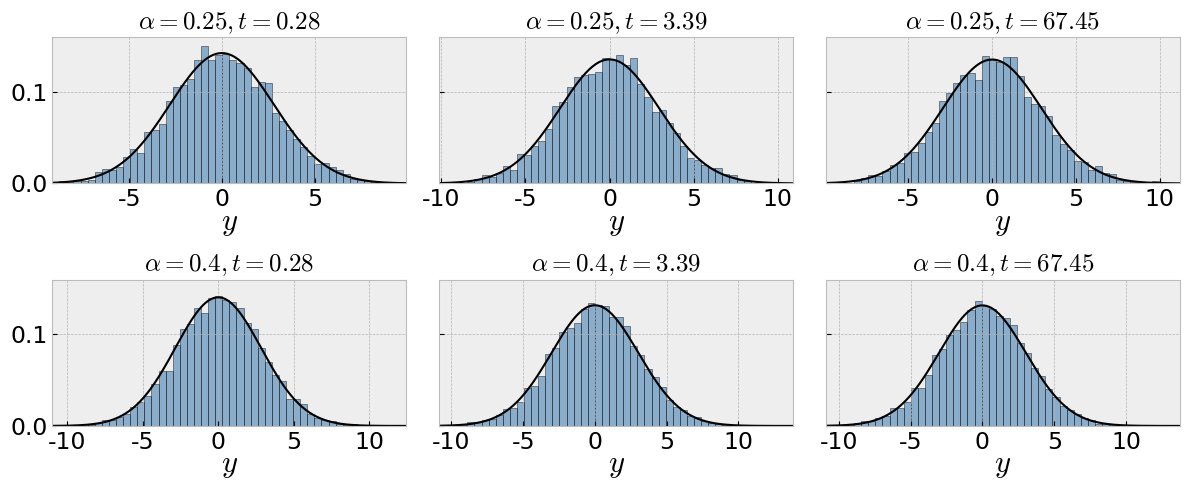

In [3]:
kappa = 0.4
kappastar = 0.3
lam = 0.0

path = '../GDSimulations/postprocess/Fig1/'

alpha = torch.load(path + 'alpha.pt')
time = torch.load(path + 'time.pt')
Labels = torch.load(path + 'labels.pt')

indtime = [12, 21, 32]
Nt = len(indtime)

fig = plt.figure(figsize=(12, 5))


for j in range(2):
    for i in range(Nt):
        L = Labels[j][indtime[i]][0]
        Nbins = 50
        fig.add_subplot(2, Nt, 3*j+i+1)
        plt.hist(L, bins=Nbins, density=True, alpha=0.6, color='steelblue', edgecolor='black')
    
        lims = [torch.min(L), torch.max(L)]
    
        sigma_hat = torch.sqrt(torch.mean(L**2))
        x = np.linspace(lims[0], lims[1], 500)
        plt.plot(x, norm.pdf(x, 0, sigma_hat), color='black', lw=1.5)
    
        ax = plt.gca()

        plt.ylim(0., 0.16)

        if i > 0:
            ax.set_yticklabels([]) 
    
        plt.title(r'$\alpha = {0}, t = {1}$'.format(round(alpha[j].item(), 2), round(time[indtime[i]].item(), 2)), fontsize=18)    
        plt.xlabel(r'$y$', labelpad=-2)
        plt.xlim(lims)

plt.tight_layout()
plt.savefig('Figure1.pdf', format='pdf')
plt.show()

#### **Figure 2**

C:\Users\simartin\AppData\Local\Temp\ipykernel_6788\4061213910.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


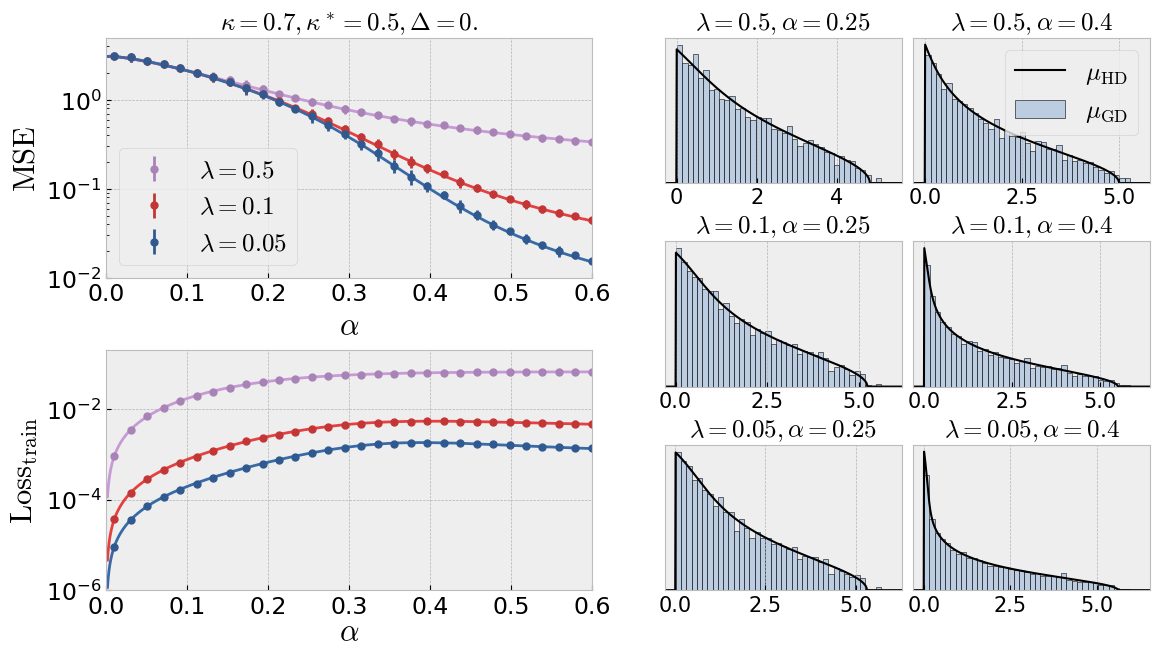

In [25]:
kappa = 0.7
kappastar = 0.5
Delta = 0.
lam = np.array([0.5, 0.1, 0.05])

with open('../HDSimulations/Simulators/SimHD_Figure2.pickle', "rb") as file:
    SHD = pickle.load(file)

ind_colors = [11, 0, 8]

path = '../GDSimulations/postprocess/Fig2/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
Loss = torch.load(path + 'loss.pt')
alphaZ = torch.load(path + 'alphaZ.pt')
Z = torch.load(path + 'Z.pt')


fig = plt.figure(figsize=(12, 6.5))
outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.15)
left_grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], hspace=0.3)
ax1 = fig.add_subplot(left_grid[0])
ax2 = fig.add_subplot(left_grid[1])
right_grid = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=outer[1], hspace=0.4, wspace=0.05)
axes_right = []
for i in range(6):
    axes_right.append(fig.add_subplot(right_grid[i]))

for j in range(3):
    a = alpha[j]
    M = MSE[j]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    ax1.errorbar(a, mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=5, label=r'$\lambda = {}$'.format(lam[j]))
    
    ax1.plot(SHD.alpha[j], SHD.mse[j], color=colors[ind_colors[j]], linewidth=2)

ax1.set_ylabel(r'$\mathrm{MSE}$')
ax1.set_xlabel(r'$\alpha$')
ax1.legend()
ax1.set_title(r'$\kappa = {0}, \kappa^* = {1}, \Delta = 0.$'.format(kappa, kappastar), fontsize=18)
ax1.set_xlim(0., 0.6)
ax1.set_ylim(1e-2, 5)
ax1.set_yscale('log')

for j in range(3):
    a = alpha[j]
    M = Loss[j]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    ax2.errorbar(a, mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=5, label=r'$\lambda = {}$'.format(lam[j]))

    ax2.plot(SHD.alpha[j], SHD.loss[j], color=colors[ind_colors[j]], linewidth=2)

ax2.set_ylabel(r'$\mathrm{Loss}_\mathrm{train}$', fontsize=22)
ax2.set_xlabel(r'$\alpha$', labelpad=0, fontsize=22)
ax2.set_xlim(0., 0.6)
ax2.set_ylim(1e-6, 0.2)
ax2.set_yscale('log')

count = 0
nbins = 40

for j in range(3):
    for k in range(2):
        eigZ = torch.linalg.eigvalsh(Z[j][k]).reshape(-1)
        eigZZ = eigZ[eigZ > 1e-2]
        r = eigZZ.shape[0] / eigZ.shape[0]
        ia = torch.argmin((SHD.alpha[j] - alphaZ[k])**2)
        minval = torch.min(torch.abs(SHD.alpha[j] - alphaZ[k]))
        xi_val = SHD.xi_new[j][ia]
        q_val = SHD.q[j][ia]

        omega = mhd.compute_omega(xi_val, kappa, kappastar)
        cutoff = max(omega, q_val)
        X = torch.linspace(0, 10, 1000)
        dens = [mhd.rho(x, xi_val, kappastar) / r if x > q_val else 0 for x in X]
        axes_right[count].plot(X - q_val, dens, color='black', label=r'$\mu_{\mathrm{HD}}$', linewidth=1.5)
    
        M1 = torch.min(eigZZ)
        M2 = torch.max(eigZZ)
        bins = torch.linspace(M1, M2, nbins)
        countsZ, _ = np.histogram(eigZZ, bins=bins, density=True)

        axes_right[count].hist(bins[:-1], bins, weights=countsZ, color='lightsteelblue', ec='black', density=True, alpha=0.8, label=r'$\mu_{\mathrm{GD}}$')

        H = np.max(countsZ[1:])
        axes_right[count].set_yticks([])
        if count == 1:
            axes_right[count].legend()

        axes_right[count].tick_params(axis='x', labelsize=15)
        axes_right[count].set_title(r'$\lambda = {0}, \alpha = {1}$'.format(lam[j], round(alphaZ[k].item(), 3)), fontsize=18)

        axes_right[count].set_xlim(-0.3, 1.1 * M2)
        count += 1

plt.tight_layout()
fig.subplots_adjust(left=0.1, right=0.97, top=0.95, bottom=0.1)
plt.savefig('Figure2.pdf', format='pdf')
plt.show()

#### **Figure 3**

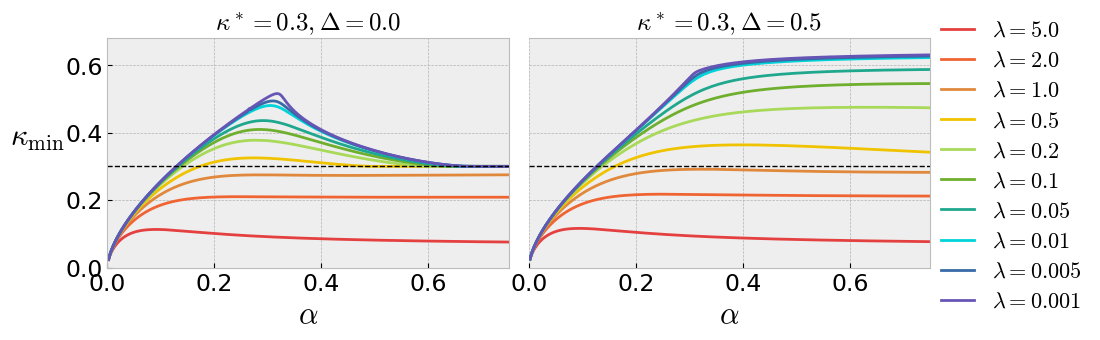

In [6]:
with open('../HDSimulations/Simulators/SimHD_Figure3A.pickle', "rb") as file:
    SHD = pickle.load(file)

with open('../HDSimulations/Simulators/SimHD_Figure3B.pickle', "rb") as file:
    SHD_noise = pickle.load(file)

kappa = 1
kappastar = 0.3
lam = np.array([5.0, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001])
Delta = np.array([0., 0.5])

ind_colors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axes = plt.subplots(1, 2, figsize=(9.5, 3.5), sharey=True)
axes = axes.flatten()

for i in range(len(lam)):
    axes[0].plot(SHD.alpha[i], SHD.rank[i], color=colors[ind_colors[i]], label=r'$\lambda = {}$'.format(lam[i]))

axes[0].axhline(kappastar, color='black', linestyle='dashed', linewidth=1)

axes[0].set_xlim(0, 0.75)
axes[0].set_ylim(0., 0.68)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\kappa_\min$', rotation=0, labelpad=20)
axes[0].set_title(r'$\kappa^* = {0}, \Delta = {1}$'.format(0.3, 0.), fontsize=18)

for i in range(len(lam)):
    axes[1].plot(SHD_noise.alpha[i], SHD_noise.rank[i], color=colors[ind_colors[i]], label=r'$\lambda = {}$'.format(lam[i]))


axes[1].axhline(kappastar, color='black', linestyle='dashed', linewidth=1)

axes[1].set_xlim(0, 0.75)
axes[1].set_ylim(0., 0.68)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_title(r'$\kappa^* = {0}, \Delta = {1}$'.format(0.3, 0.5), fontsize=18)
axes[1].grid(True, axis='y')
axes[1].tick_params(left=False, labelleft=False)
axes[1].spines['left'].set_visible(False)  

plt.tight_layout()
plt.subplots_adjust(wspace=0.05) 
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.165, 0.99), fontsize=16, labelspacing=0.32, handlelength=1.5, frameon=False)

plt.savefig('Figure3.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### **Figure 4**

C:\Users\simartin\AppData\Local\Temp\ipykernel_6788\3870740868.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


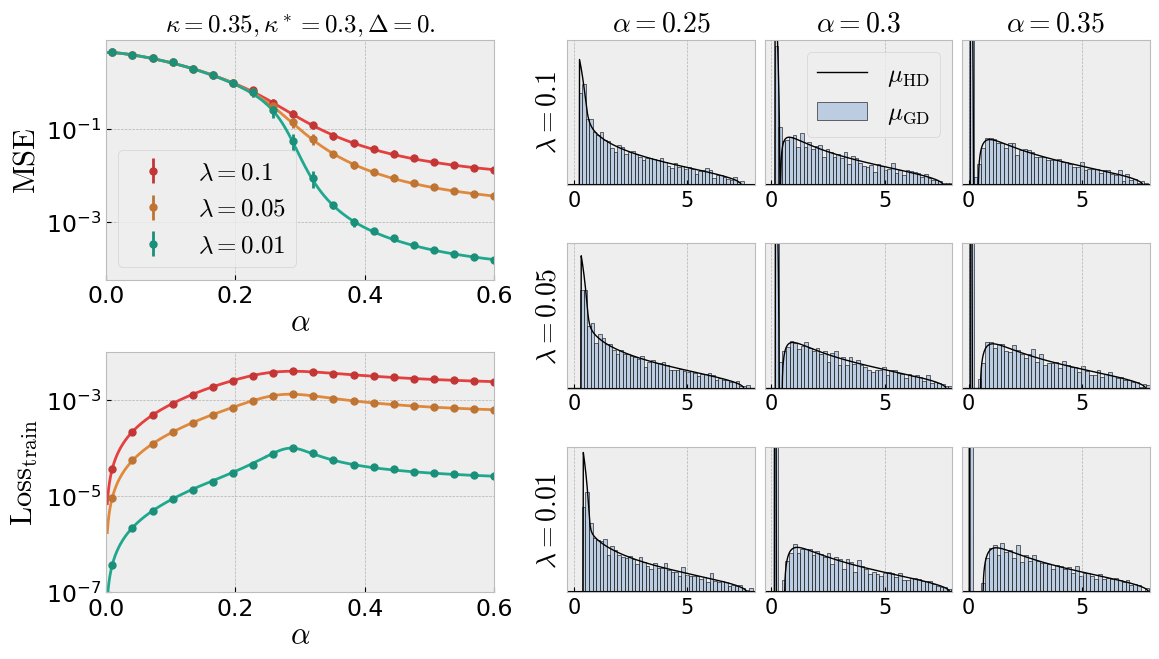

In [7]:
ind_colors = [0, 2, 6]

kappa = 0.35
kappastar = 0.3
lam = np.array([0.1, 0.05, 0.01])

with open('../HDSimulations/Simulators/SimHD_Figure4.pickle', "rb") as file:
    SHD = pickle.load(file)

path = '../GDSimulations/postprocess/Fig4/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
Loss = torch.load(path + 'loss.pt')
alphaZ = torch.load(path + 'alphaZ.pt')
Z = torch.load(path + 'Z.pt')


fig = plt.figure(figsize=(12, 6.5))
outer = gridspec.GridSpec(1, 2, width_ratios=[2, 3], wspace=0.15)
left_grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], hspace=0.3)
ax1 = fig.add_subplot(left_grid[0])
ax2 = fig.add_subplot(left_grid[1])
right_grid = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[1], hspace=0.4, wspace=0.05)
axes_right = []
for i in range(9):
    axes_right.append(fig.add_subplot(right_grid[i]))

for j in range(3):
    a = alpha[j]
    M = MSE[j]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    
    ax1.errorbar(a, mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=5, label=r'$\lambda = {}$'.format(lam[j]))
    ax1.plot(SHD.alpha[j], SHD.mse[j], color=colors[ind_colors[j]], linewidth=2)

ax1.set_ylabel(r'$\mathrm{MSE}$')
ax1.set_xlabel(r'$\alpha$', labelpad=0)
ax1.legend()
ax1.set_title(r'$\kappa = {0}, \kappa^* = {1}, \Delta = 0.$'.format(kappa, kappastar), fontsize=18)
ax1.set_xlim(0., 0.6)
ax1.set_yscale('log')

for j in range(3):
    a = alpha[j]
    M = Loss[j]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    
    ax2.errorbar(a, mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=5, label=r'$\lambda = {}$'.format(lam[j]))
    ax2.plot(SHD.alpha[j], SHD.loss[j], color=colors[ind_colors[j]], linewidth=2)

ax2.set_ylim(1e-7, 1e-2)
ax2.set_ylabel(r'$\mathrm{Loss}_\mathrm{train}$')
ax2.set_xlabel(r'$\alpha$', labelpad=0)
ax2.set_xlim(0., 0.6)
ax2.set_yscale('log')


count = 0
ind_alpha = [1, 2, 3]
nbins = 50

for j in range(3):
    for k in range(3):
        eigZ = torch.linalg.eigvalsh(Z[j][k]).reshape(-1)
        eigZZ = eigZ[eigZ > 1e-5]
        r = eigZZ.shape[0] / eigZ.shape[0]
        ia = torch.argmin((SHD.alpha[j] - alphaZ[k])**2)
        minval = torch.min(torch.abs(SHD.alpha[j] - alphaZ[k]))
        xi_val = SHD.xi_new[j][ia]
        q_val = SHD.q[j][ia]

        omega = mhd.compute_omega(xi_val, kappa, kappastar)
        cutoff = max(omega, q_val)
        X = torch.linspace(0, 10, 1000)
        dens = [mhd.rho(x, xi_val, kappastar) / r if x > cutoff else 0 for x in X]
        axes_right[count].plot(X - q_val, dens, color='black', label=r'$\mu_{\mathrm{HD}}$', linewidth=1.)
    
        M1 = torch.min(eigZZ)
        M2 = torch.max(eigZZ)
        bins = torch.linspace(M1, M2, nbins)
        countsZ, _ = np.histogram(eigZZ, bins=bins, density=True)

        axes_right[count].hist(bins[:-1], bins, weights=countsZ, color='lightsteelblue', ec='black', density=True, alpha=0.8, label=r'$\mu_{\mathrm{GD}}$')
        axes_right[count].axhline(0, color='black', linewidth=1.5)
        
        axes_right[count].set_yticks([])
        if count == 1:
            axes_right[count].legend()

        axes_right[count].tick_params(axis='x', labelsize=15)

        if j == 0:
            axes_right[count].set_title(r'$\alpha = {}$'.format(round(alphaZ[k].item(), 3)), fontsize=20)

        axes_right[count].set_xlim(-0.3, 8.)
        axes_right[count].set_ylim(0., 0.7)

        if k == 0:
            axes_right[count].set_ylabel(r'$\lambda = {}$'.format(lam[j]), fontsize=20)

        count += 1

plt.tight_layout()
fig.subplots_adjust(left=0.1, right=0.97, top=0.95, bottom=0.1)
plt.savefig('Figure4.pdf', format='pdf')
plt.show() 

#### **Figure 5**

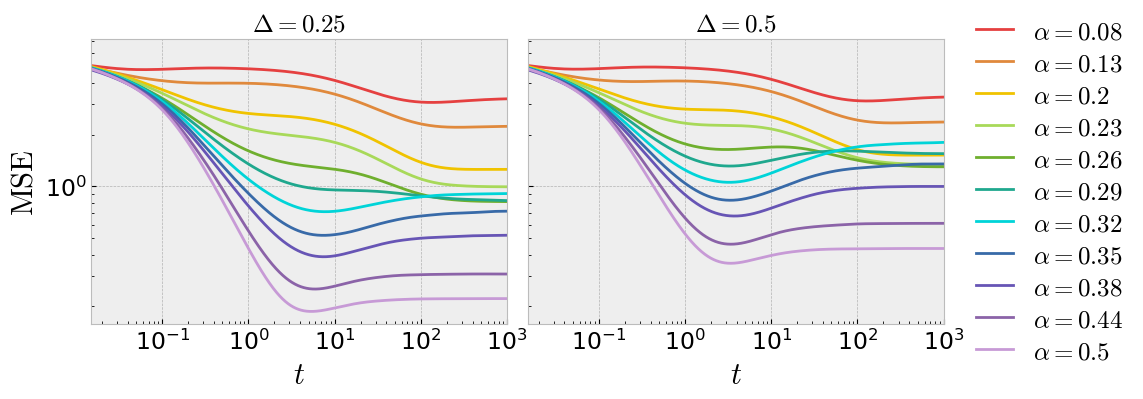

In [8]:
ind_colors = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

kappa = 0.4
kappastar = 0.3
lam = 0.01
delta = [0.25, 0.5]

path = '../GDSimulations/postprocess/Fig5/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
time = torch.load(path + 'time.pt')


fig, axes = plt.subplots(1, 2, figsize=(11, 3.7), sharey=True)
axes = axes.flatten()

for i in range(2):
    for j in range(len(alpha[i])):
        M = MSE[i][j]
        axes[i].plot(time, torch.mean(M, dim=-1), color=colors[ind_colors[j]], label=r'$\alpha = {}$'.format(round(alpha[i][j].item(), 3)))

    axes[i].set_title(r'$\Delta = {0}$'.format(delta[i]), fontsize=18)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel(r'$t$')
    if i == 0:
        axes[i].set_ylabel(r'$\mathrm{MSE}$')
    axes[i].set_xlim(1.5e-2, 1e3)

plt.subplots_adjust(wspace=0.05) 

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(0.92, 0.47), borderaxespad=0, fontsize=18, labelspacing=0.32, handlelength=1.5, frameon=False)
plt.savefig('Figure5.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### **Figure 6**

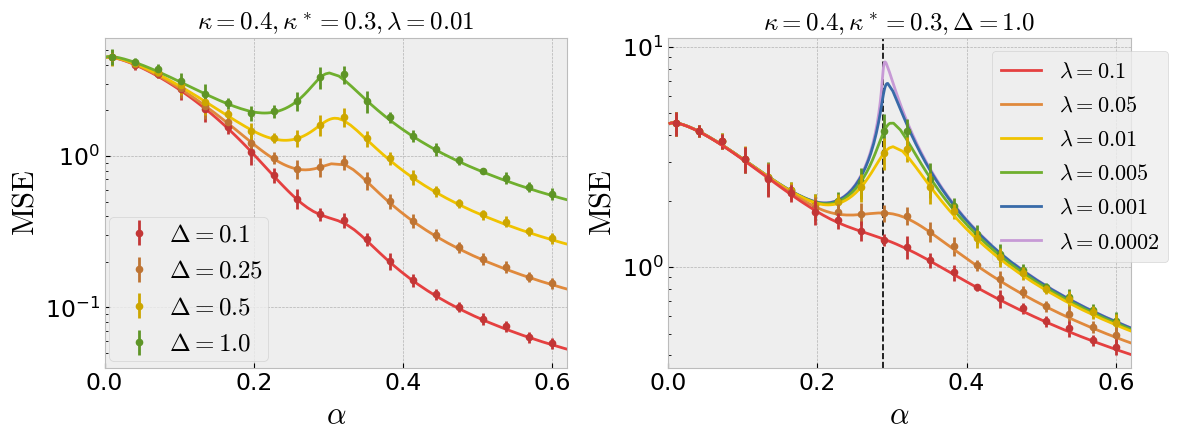

In [9]:
fig = plt.figure(figsize=(12, 4.5))

kappa = 0.4
kappastar = 0.3

lam1 = 0.01
delta1 = [0.1, 0.25, 0.5, 1.0]
lam2 = [0.1, 0.05, 0.01, 0.005]
delta2 = 1.0

path = '../GDSimulations/postprocess/Fig6/'

alpha1 = torch.load(path + 'alpha1.pt')
MSE1 = torch.load(path + 'MSE1.pt')
alpha2 = torch.load(path + 'alpha2.pt')
MSE2 = torch.load(path + 'MSE2.pt')

with open('../HDSimulations/Simulators/SimHD_Figure6A.pickle', "rb") as file:
    SHD1 = pickle.load(file)

with open('../HDSimulations/Simulators/SimHD_Figure6B.pickle', "rb") as file:
    SHD2 = pickle.load(file)

ind_colors = [0, 2, 3, 5]

fig.add_subplot(1, 2, 1)
for i in range(len(delta1)):
    M = MSE1[i]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    
    plt.plot(SHD1.alpha[i], SHD1.mse[i], color=colors[ind_colors[i]])
    plt.errorbar(alpha1[i], mean, yerr=2*sigma, color=colors_dark[ind_colors[i]], fmt='o', ms=4.5, label=r'$\Delta = {}$'.format(delta1[i]))

plt.legend(loc=(0.01, 0.02), handletextpad=0.2,  borderpad=0.2)
plt.yscale('log')
plt.xlim(0., 0.62)
plt.ylim(0.04, 6)
plt.title(r'$\kappa = {0}, \kappa^* = {1}, \lambda = {2}$'.format(kappa, kappastar, lam1), fontsize=18)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathrm{MSE}$')

fig.add_subplot(1, 2, 2)
ind_Delta = 3
ind_colors = [10, 7, 5, 3, 2, 0]

lamb = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0002]

ind_colors = [0, 2, 3, 5, 8, 11]

for i in range(len(lam2)):
    M = MSE2[i]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    plt.errorbar(alpha2[i], mean, yerr=2*sigma, color=colors_dark[ind_colors[i]], fmt='o', ms=4.5, zorder=10-i)

for i in range(len(lamb)):
    plt.plot(SHD2.alpha[i], SHD2.mse[i], color=colors[ind_colors[i]], zorder=10-i, label=r'$\lambda = {}$'.format(lamb[i]))


inter = mhd.interpolation_treshold(kappa, kappastar, delta2)[1]
plt.axvline(inter, color='black', linestyle='dashed', linewidth=1.2)

plt.legend(loc=(0.7, 0.32), handlelength=1.8, fontsize=16)
plt.yscale('log')
plt.xlim(0., 0.62)
plt.ylim(0.35, 11)
plt.title(r'$\kappa = {0}, \kappa^* = {1}, \Delta = {2}$'.format(kappa, kappastar, delta2), fontsize=18)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathrm{MSE}$')

plt.tight_layout()
plt.savefig('Figure6.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### **Figure 7**

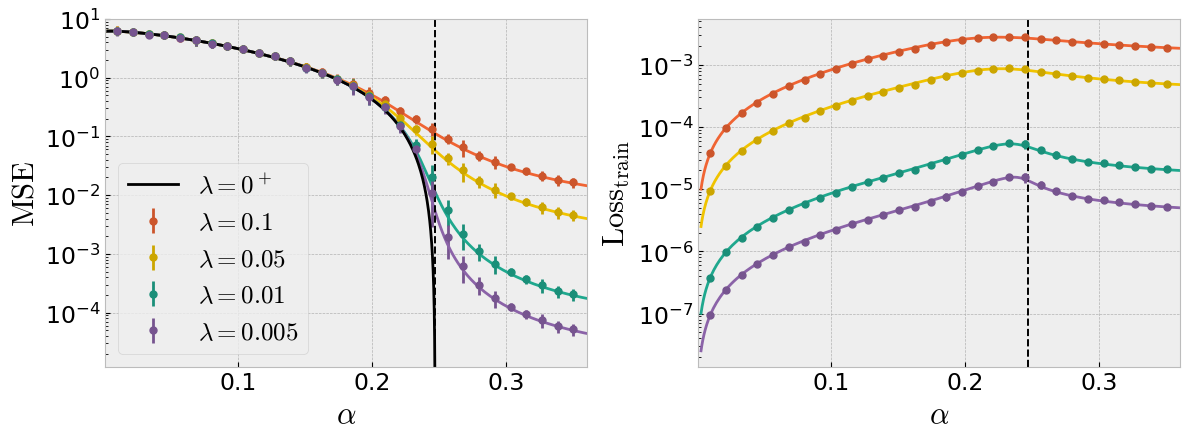

In [10]:
kappa = 0.3
kappastar = 0.2
lam = [0.1, 0.05, 0.01, 0.005]

ind_colors = [1, 3, 6, 10]

path = '../GDSimulations/postprocess/Fig7/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
Loss = torch.load(path + 'loss.pt')

with open('../HDSimulations/Simulators/SimHD_Figure7.pickle', "rb") as file:
    SHD = pickle.load(file)

alpha_st = utils.strong_threshold(kappa, kappastar)

fig = plt.figure(figsize=(12, 4.5))
fig.add_subplot(1, 2, 1)
for i in range(len(lam)):
    M = MSE[i]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - mean**2
    sigma = torch.sqrt(var)

    plt.errorbar(alpha[i], mean, yerr=2*sigma, color=colors_dark[ind_colors[i]], fmt='o', ms=5, label=r'$\lambda = {}$'.format(lam[i]))
    plt.plot(SHD.alpha[i], SHD.mse[i], color=colors[ind_colors[i]])

plt.plot(SHD.alpha[-1], SHD.mse[-1], color='black', label=r'$\lambda = 0^+$')

plt.axvline(alpha_st, color='black', linestyle='dashed', linewidth=1.4)

plt.xlim(0.001, 0.36)
plt.ylim(1.2e-5, 10)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathrm{MSE}$')
plt.legend()

plt.yscale('log')


fig.add_subplot(1, 2, 2)
for i in range(len(lam)):
    M = Loss[i]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - mean**2
    sigma = torch.sqrt(var)

    plt.errorbar(alpha[i], mean, yerr=2*sigma, color=colors_dark[ind_colors[i]], fmt='o', ms=5, label=r'$\lambda = {}$'.format(lam[i]))
    plt.plot(SHD.alpha[i], SHD.loss[i], color=colors[ind_colors[i]])

plt.axvline(alpha_st, color='black', linestyle='dashed', linewidth=1.4)

plt.xlim(0.001, 0.36)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathrm{Loss}_\mathrm{train}$')

plt.yscale('log')

plt.tight_layout()
plt.savefig('Figure7.pdf', format='pdf')
plt.show()

#### **Figure 8**

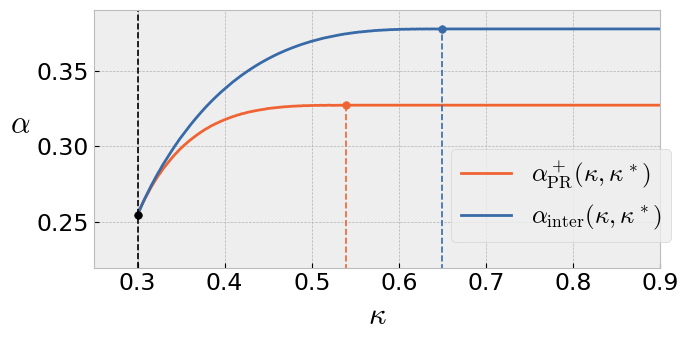

In [11]:
kappastar = 0.3

kappa = torch.linspace(kappastar, 1.1, 500)
PRthreshold = torch.tensor([utils.strong_threshold(k, kappastar) for k in kappa])
inter = torch.tensor([utils.alpha_star(k, kappastar) for k in kappa])

ind_colors = [1, 8]

fig = plt.figure(figsize=(7, 3.5))

plt.plot(kappa, PRthreshold, color=colors[ind_colors[0]], label=r'$\alpha_\mathrm{PR}^+(\kappa, \kappa^*)$')
plt.plot(kappa, inter, color=colors[ind_colors[1]], label=r'$\alpha_\mathrm{inter}(\kappa, \kappa^*)$')

plt.vlines((1+kappastar) / 2, ymin=0, ymax=inter[-1], color=colors[ind_colors[1]], linestyle='dashed', linewidth=1.2)

ind = PRthreshold < PRthreshold[-1]
klim = kappa[ind][-1]
PRlim = PRthreshold[ind][-1]
plt.vlines(klim, ymin=0, ymax=PRlim, color=colors[ind_colors[0]], linestyle='dashed', linewidth=1.2)

plt.scatter([klim], [PRlim], color=colors[ind_colors[0]], marker='o', s=30)
plt.scatter([(1+kappastar)/2], [inter[-1]], color=colors[ind_colors[1]], marker='o', s=30)
plt.scatter([kappastar], [kappastar - kappastar**2 / 2], color='black', marker='o', s=30, zorder=2)

plt.axvline(kappastar, color='black', linewidth=1.2, linestyle='dashed')

plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\alpha$', rotation=0, labelpad=12)
plt.xlim(kappastar - 0.05, 0.9)
plt.ylim(0.22, 0.39)

plt.legend(loc=(0.63, 0.1))
plt.tight_layout()
plt.savefig('Figure8.pdf')
plt.show()

#### **Figure 9**

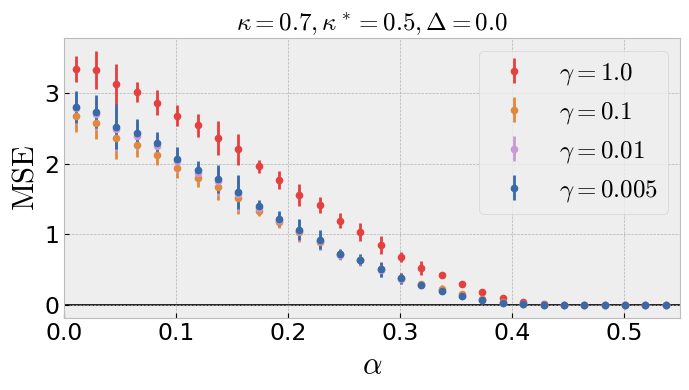

In [27]:
fig = plt.figure(figsize=(7, 4))

ind_colors = [0, 2, 11, 8]

gamma = np.array([1.0, 0.1, 0.01, 0.005])
kappa = 0.7
kappastar = 0.5
delta = 0.

path = '../GDSimulations/postprocess/Fig9/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')

for j in range(len(gamma)):
    M = MSE[j]
    mean = torch.mean(M, dim=-1)
    sigma = torch.sqrt(torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2)
    plt.errorbar(alpha[j], mean, yerr=2*sigma, color=colors[ind_colors[j]], fmt='o', ms=4.5, label=r'$\gamma = {}$'.format(gamma[j]))

plt.axhline(0, color='black', linewidth=1.2, zorder=-1)

plt.legend()

plt.title(r'$\kappa = {0}, \kappa^* = {1}, \Delta = {2}$'.format(kappa, kappastar, delta), fontsize=18)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathrm{MSE}$')

plt.xlim(0., 0.55)

plt.tight_layout()
plt.savefig('Figure9.pdf', format='pdf')
plt.show()

#### **Figure 10**

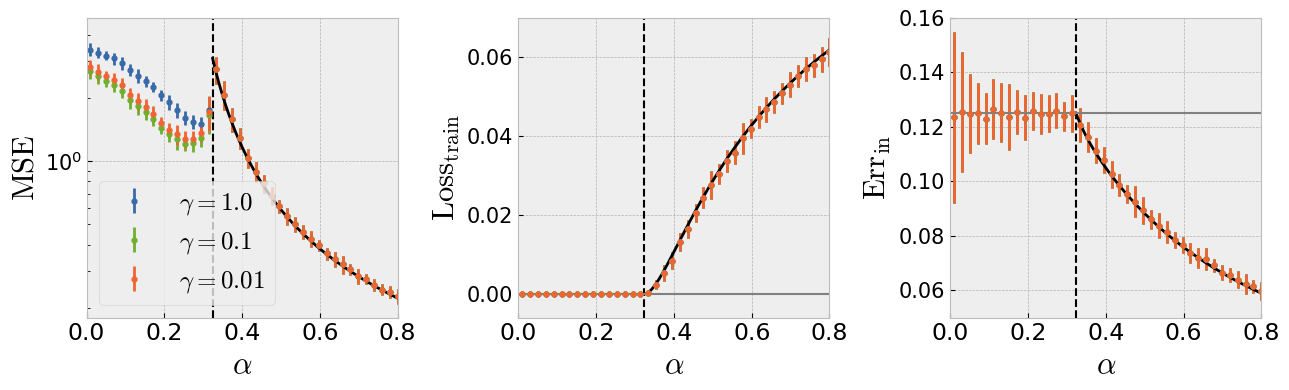

In [13]:
kappa = 0.7
kappastar = 0.5
lam = 0.
delta = 0.5
gamma = [1.0, 0.1, 0.01]

ind_colors = [8, 5, 1]

path = '../GDSimulations/postprocess/Fig10/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
Loss = torch.load(path + 'loss.pt')
ISE = torch.load(path + 'ISE.pt')

with open('../HDSimulations/Simulators/SimHD_Figure10.pickle', "rb") as file:
    SHD = pickle.load(file)

crit = SHD.rank.item()
ind = crit > 0
alphaHD = SHD.alpha.item()
MSEHD = SHD.mse.item()
LossHD = SHD.loss.item()

inter = alphaHD[ind][-1]


fig = plt.figure(figsize=(13, 4))
fig.add_subplot(1, 3, 1)
for j in range(len(gamma)):
    M = MSE[j]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    plt.errorbar(alpha[j], mean, yerr=2*sigma, color=colors[ind_colors[j]], fmt='o', ms=3.5, label=r'$\gamma = {0}$'.format(gamma[j]))

plt.plot(alphaHD[ind], MSEHD[ind], color='black')
plt.axvline(inter, color='black', linestyle='dashed', linewidth=1.5)
plt.legend()
plt.yscale('log')
plt.xlim(0., 0.8)
plt.ylim(0.18, 4.8)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathrm{MSE}$')
plt.yticks(fontsize=15)


fig.add_subplot(1, 3, 2)
for j in range(len(gamma)):
    M = Loss[j]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    plt.errorbar(alpha[j], mean, yerr=2*sigma, color=colors[ind_colors[j]], fmt='o', ms=3.5, label=r'$\gamma = {0}$'.format(gamma[j]))

L = (MSEHD[ind] + delta / 2) / (2 * alphaHD[ind]**2) * crit[ind]**2

plt.plot(alphaHD[ind], L, color='black')
plt.axvline(inter, color='black', linestyle='dashed', linewidth=1.5)
plt.axhline(0, color='gray', linewidth=1.5)
plt.xlim(0., 0.8)
plt.ylim(-0.006, 0.07)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathrm{Loss}_\mathrm{train}$')
plt.yticks(fontsize=15)


fig.add_subplot(1, 3, 3)
for j in range(len(gamma)):
    M = ISE[j]
    mean = torch.mean(M, dim=-1)
    var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
    sigma = torch.sqrt(var)
    plt.errorbar(alpha[j], mean, yerr=2*sigma, color=colors[ind_colors[j]], fmt='o', ms=3.5, label=r'$\gamma = {0}$'.format(gamma[j]))

L = MSEHD[ind] / (2 * alphaHD[ind]**2) * crit[ind]**2 + delta / 4 * (1 - crit[ind] / alphaHD[ind])**2

plt.plot(alphaHD[ind], L, color='black')
plt.axvline(inter, color='black', linestyle='dashed', linewidth=1.5)
plt.axhline(delta / 4, color='gray', linewidth=1.5)
plt.xlim(0., 0.8)
plt.ylim(0.05, 0.16)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathrm{Err}_\mathrm{in}$')
plt.yticks(fontsize=15)

plt.tight_layout()
plt.savefig('Figure10.pdf', format='pdf')
plt.show()

#### **Figure 11**

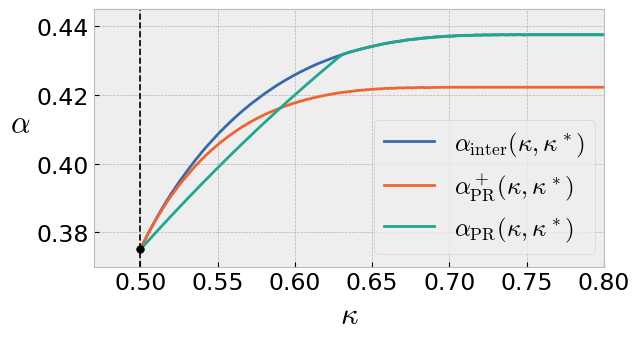

In [14]:
kappastar = 0.5

kappa = torch.linspace(kappastar, 1.1, 500)
PR_reg = torch.tensor([utils.strong_threshold(k, kappastar) for k in kappa])
PR = torch.tensor([utils.PR_threshold(k, kappastar) for k in kappa])
inter = torch.tensor([utils.alpha_star(k, kappastar) for k in kappa])

ind_colors = [8, 1, 6]
curve_colors  = [colors[i] for i in ind_colors]

fig = plt.figure(figsize=(6.5, 3.5))

plt.plot(kappa, inter, color=curve_colors[0], label=r'$\alpha_\mathrm{inter}(\kappa, \kappa^*)$', linewidth=2)
plt.plot(kappa, PR_reg, color=curve_colors[1], label=r'$\alpha_\mathrm{PR}^+(\kappa, \kappa^*)$', linewidth=2)
plt.plot(kappa, PR, color=curve_colors[2], label=r'$\alpha_\mathrm{PR}(\kappa, \kappa^*)$', linewidth=2)

ind = PR_reg < PR_reg[-1]
klim = kappa[ind][-1]
PRlim = PR_reg[ind][-1]

ind = PR < kappa - kappa**2 / 2
klim = kappa[ind][0]
PRlim = PR[ind][0]

plt.scatter([kappastar], [kappastar - kappastar**2 / 2], color='black', marker='o', s=30, zorder=2)
plt.axvline(kappastar, color='black', linestyle='dashed', linewidth=1.2)

lower = torch.minimum(PR, PR_reg)
higher = torch.maximum(PR, PR_reg)

I1 = PR_reg > PR
I2 = PR_reg < PR

plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\alpha$', rotation=0, labelpad=12)
plt.xlim(kappastar - 0.03, 0.8)
plt.ylim(0.37, 0.445)
plt.legend(loc=(0.55, 0.05))

plt.tight_layout()
plt.savefig('Figure11.pdf')
plt.show()

#### **Figure 12**

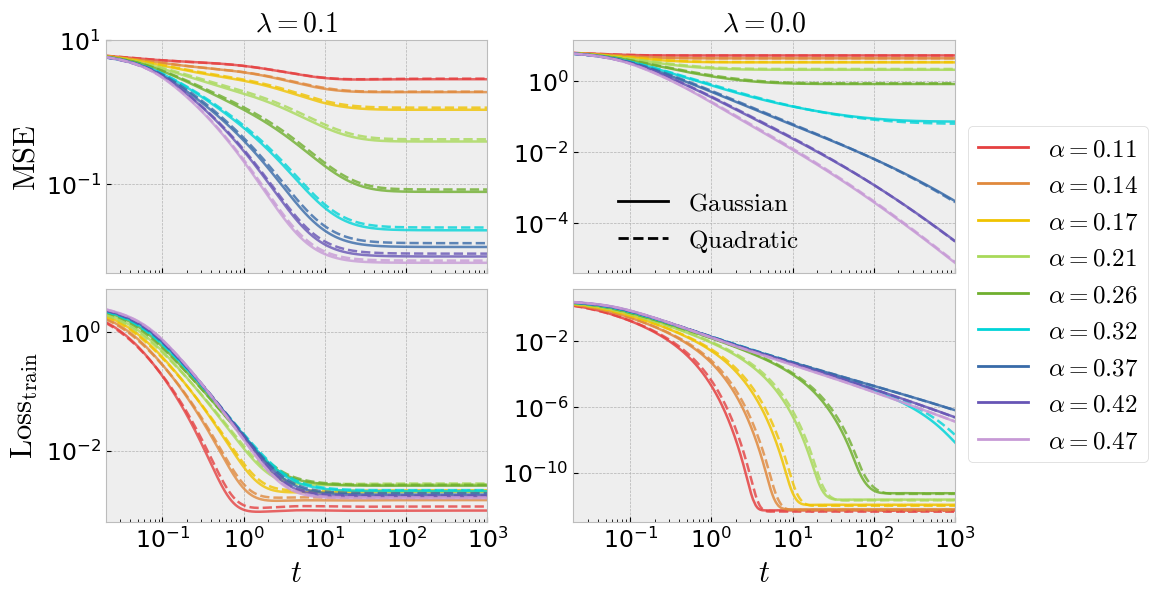

In [15]:
ind_colors = [0, 2, 3, 4, 5, 7, 8, 9, 11]

kappa = 0.5
kappastar = 0.2
lam = [0.1, 0.]
delta = 0.

d = 150

path = '../GDSimulations/postprocess/Fig12/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
Loss = torch.load(path + 'loss.pt')
time = torch.load(path + 'time.pt')


fig = plt.figure(figsize=(12, 6))
for k in range(2):
    ax = fig.add_subplot(2, 2, k+1)
    MQ = MSE[0][k]
    tQ = time[0][k]
    MG = MSE[1][k]
    tG = time[1][k]
    alphaQ = alpha[0][k]
    alphaG = alpha[1][k]

    for i in range(len(alphaG)):
        if k == 1:
            ax.plot(tG, torch.mean(MG[i], dim=-1), color=colors[ind_colors[i]], 
                    label=r'$\alpha = {}$'.format(round(alphaG[i].item(), 3)),
                    alpha=0.85, linewidth=1.8)
        else:
            ax.plot(tG, torch.mean(MG[i], dim=-1), color=colors[ind_colors[i]], alpha=0.8, linewidth=1.8)

        ax.plot(tQ, torch.mean(MQ[i], dim=-1), color=colors[ind_colors[i]], linestyle='--', alpha=0.8, linewidth=1.8)

    ax.set_xscale('log')
    ax.set_yscale('log')
    if k == 0:
        ax.set_ylabel(r'$\mathrm{MSE}$')
    ax.set_xlim(2e-2, 1e3)
    ax.set_title(r'$\lambda = {0}$'.format(lam[k]), fontsize=20)
    ax.set_xticklabels([])

model_lines = [Line2D([0], [0], color='black', linestyle='-', label=r'$\mathrm{Gaussian}$'),
               Line2D([0], [0], color='black', linestyle='--', label=r'$\mathrm{Quadratic}$')]

fig.legend(handles=model_lines, loc='lower left', bbox_to_anchor=(0.5, 0.53), frameon=False)

for k in range(2):
    ax = fig.add_subplot(2, 2, k+3)
    MQ = Loss[0][k]
    tQ = time[0][k]
    MG = Loss[1][k]
    tG = time[1][k]
    alphaQ = alpha[0][k]
    alphaG = alpha[1][k]
    
    for i in range(len(alphaG)):
        if k == 1:
            ax.plot(tG, torch.mean(MG[i], dim=-1), color=colors[ind_colors[i]],
                    label=r'$\alpha = {}$'.format(round(alphaG[i].item(), 3)),
                    alpha=0.85, linewidth=1.8)
        else:
            ax.plot(tG, torch.mean(MG[i], dim=-1), color=colors[ind_colors[i]], alpha=0.8, linewidth=1.8)
            
        ax.plot(tQ, torch.mean(MQ[i], dim=-1), color=colors[ind_colors[i]], linestyle='--', alpha=0.8, linewidth=1.8)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$t$')
    if k == 0:
        ax.set_ylabel(r'$\mathrm{Loss}_\mathrm{train}$')
    ax.set_xlim(2e-2, 1e3)

plt.tight_layout()
fig.subplots_adjust(right=0.8, bottom=0.12)

handles = [Line2D([0], [0], color=colors[ind_colors[i]], lw=2, label=r'$\alpha = {}$'.format(round(alphaG[i].item(), 3))) for i in range(len(alphaG))]
first_legend = fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.8, 0.5), facecolor='white')

plt.savefig('Figure12.pdf', format='pdf')
plt.show()

#### **Figure 13**

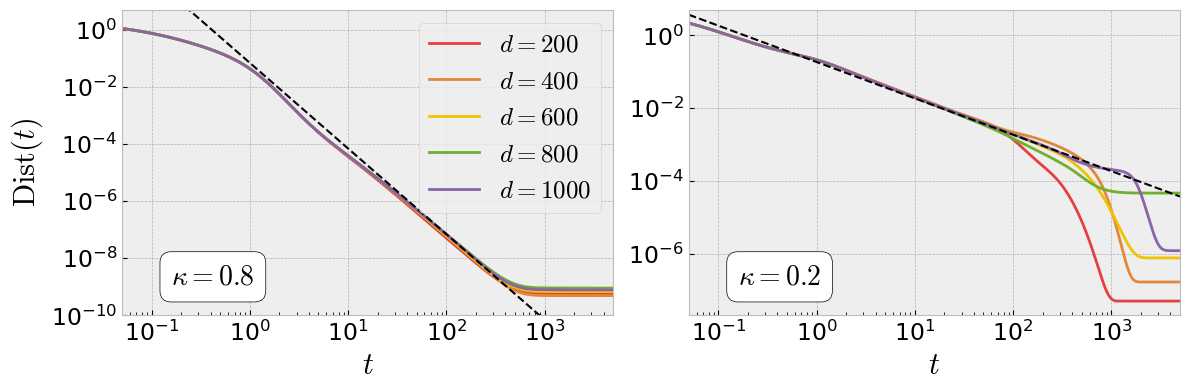

In [16]:
import mpmath as mp

def compute_MSE(kappa, s):
    v = np.linspace(-2, 2, 1000)
    ind = np.argmin((kappa - utils.moment_0(v)) ** 2)
    omega = v[ind]
    thresh = max(-s, omega)
    return 1 + s ** 2 - utils.moment_2(thresh) - 2 * shift * utils.moment_1(thresh) - s ** 2 *  utils.moment_0(thresh)

def compute_omega(kappa):
    v = np.linspace(-2, 2, 1000)
    ind = np.argmin((kappa - utils.moment_0(v)) ** 2)
    return v[ind]

def positive_eig(s):
    return utils.moment_0(-s)

def powerlaw(kA, k, s):
    if k >= min(1, kA):
        return 3, (np.pi ** 2 / 12 - float(mp.zeta(3)) / 2) * utils.sigma(-s)
    else:
        omega = compute_omega(k)
        return 1, np.log(2) * (omega + s) ** 2 * utils.sigma(omega + s)

d = [200, 400, 600, 800, 1000]
kappa = [0.8, 0.2]
s = 0.

path = '../GDSimulations/postprocess/Fig13/'

Dist = torch.load(path + 'dist.pt')
time = torch.load(path + 'time.pt')

fig = plt.figure(figsize=(12, 4))


ind_colors = [0, 2, 3, 5, 10]

for i in range(len(kappa)):
    fig.add_subplot(1, 2, i+1)
    for j in range(len(d)):
        D = torch.mean(Dist[j][i], dim=-1)
        plt.plot(time, D, color=colors[ind_colors[j]], label=r'$d = {}$'.format(d[j]))

    kappaA = 1/2
    exp, cst = powerlaw(kappaA, kappa[i], 0.)
    
    plt.plot(time, cst * time**(-exp), color='black', linestyle='dashed', linewidth=1.5)

    if i == 0:
        plt.legend()

    ax = plt.gca()
    plt.text(0.1, 0.1, r'$\kappa = {}$'.format(kappa[i]), transform=ax.transAxes, bbox=dict(facecolor="1.", boxstyle="round,pad=0.4", edgecolor='black'), fontsize=20)
 
    plt.xlabel(r'$t$')
    if i == 0:
        plt.ylabel(r'$\mathrm{Dist}(t)$')
    plt.xscale('log')
    plt.yscale('log')

    ylims = [[1e-10, 5], [2e-8, 5]]
    plt.ylim(ylims[i][0], ylims[i][1])
    plt.xlim(5e-2, 5e3)

plt.tight_layout()
plt.savefig('Figure13.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### **Figure 14**

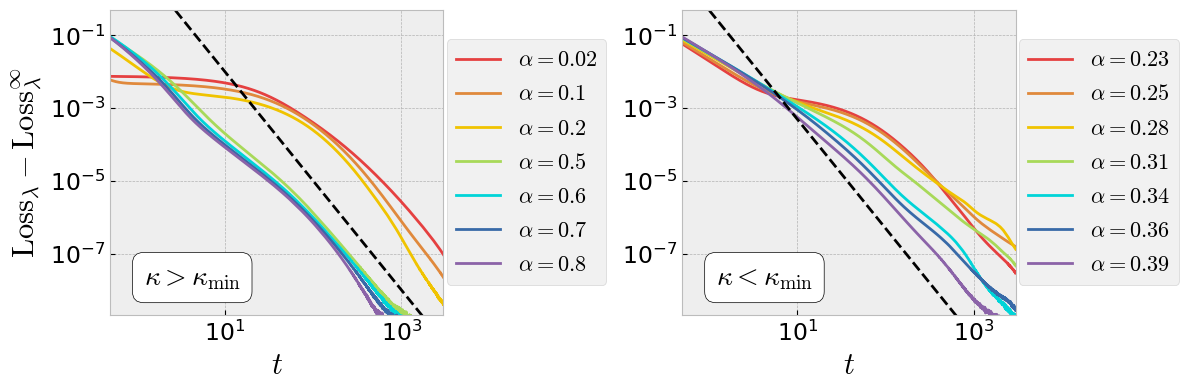

In [17]:
kappa = 0.4
kappastar = 0.3
lam = 0.01
delta = 0.

path = '../GDSimulations/postprocess/Fig14/'

alpha = torch.load(path + 'alpha.pt')
Loss = torch.load(path + 'loss_reg.pt')
time = torch.load(path + 'time.pt')

with open('../HDSimulations/Simulators/SimHD_Figure3A.pickle', "rb") as file:
    SHD = pickle.load(file)

ind_lam_HD = 7

def limit_length(x, Nmax):
    x = np.asarray(x)
    if len(x) <= Nmax:
        return x
    idx = np.linspace(0, len(x) - 1, Nmax, dtype=int)
    return x[idx]

stability = [[], []]
# 0 = stable / 1 = unstable
rank = SHD.rank[ind_lam_HD]
alphaHD = SHD.alpha[ind_lam_HD]
for j in range(len(alpha)):
    indHD = torch.argmin((alphaHD - alpha[j])**2)
    rHD = rank[indHD]
    if kappa < rHD:  # unstable
        stability[1].append(j)
    else:
        stability[0].append(j)
            

fig = plt.figure(figsize=(12, 4))

count = 0
t_pl = torch.logspace(-1, 3.5, 500)

ylims = [[2e-9, 0.5], [2e-9, 0.5]]

fac = [10, 0.5]

Nmax = 7
ind_colors = [0, 2, 3, 4, 7, 8, 10]

text = ['$\kappa > \kappa_{\min}$', '$\kappa < \kappa_{\min}$']

for k in range(2):
    ax = fig.add_subplot(1, 2, count+1)
    ind_alpha = limit_length(stability[k], Nmax)
    
    for i in range(len(ind_alpha)):      
        l = Loss[ind_alpha[i]]
        diff = l - l[-1]
        mean = torch.mean(diff, dim=-1)
        plt.plot(time, mean, color=colors[ind_colors[i]], label=r'$\alpha = {}$'.format(round(alpha[ind_alpha[i]].item(), 3)))
    
    plt.plot(t_pl, fac[k] / t_pl**3, color='black', linestyle='dashed')

    plt.legend(fontsize=16, loc=(1.01, 0.1))
    if k == 0:
        plt.ylabel(r'$\mathrm{Loss}_\lambda - \mathrm{Loss}_\lambda^\infty$')
    plt.xlabel(r'$t$')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0.5, 3e3)
    plt.ylim(ylims[count][0], ylims[count][1])

    plt.text(0.1, 0.1, text[k], transform=ax.transAxes, bbox=dict(facecolor="1.", boxstyle="round,pad=0.4", edgecolor='black'), fontsize=20)

    count += 1

plt.tight_layout()
plt.savefig('Figure14.pdf', format='pdf')
plt.show()

#### **Figure 15**

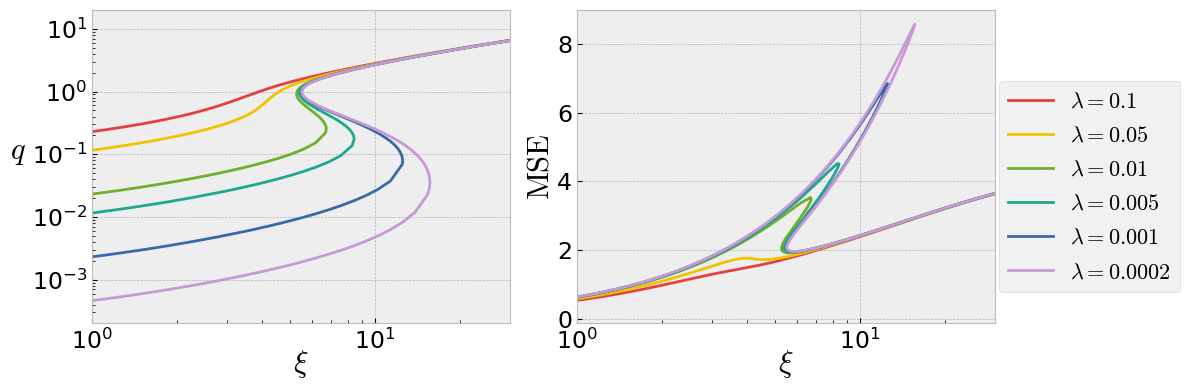

In [18]:
kappa = 0.4
kappastar = 0.3
delta = 1.0

with open('../HDSimulations/Simulators/SimHD_Figure6B.pickle', "rb") as file:
    SHD = pickle.load(file)

fig = plt.figure(figsize=(12, 4))

alpha_inter = mhd.interpolation_treshold(kappa, kappastar, delta)[1] 
ind_colors = [0, 3, 5, 6, 8, 11]
lamb = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0002]

fig.add_subplot(1, 2, 1)
for i in range(len(lamb)):
    plt.plot(SHD.xi_new[i], SHD.q[i], color=colors[ind_colors[i]], label=r'$\lambda = {}$'.format(lamb[i]), linewidth=2)

plt.xlabel(r'$\xi$', labelpad=-4)
plt.ylabel(r'$q$', rotation=0, labelpad=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.0, 30)
plt.ylim(2e-4, 20)

fig.add_subplot(1, 2, 2)
for i in range(len(lamb)):
    plt.plot(SHD.xi_new[i], SHD.mse[i], color=colors[ind_colors[i]], label=r'$\lambda = {}$'.format(lamb[i]), linewidth=2)

plt.xlabel(r'$\xi$', labelpad=-4)
plt.ylabel(r'$\mathrm{MSE}$', labelpad=2)
plt.xscale('log')
plt.xlim(1.0, 30)
plt.legend(loc=(1.01, 0.1), fontsize=16)

plt.tight_layout()
plt.savefig('Figure15.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### **Figure 16**

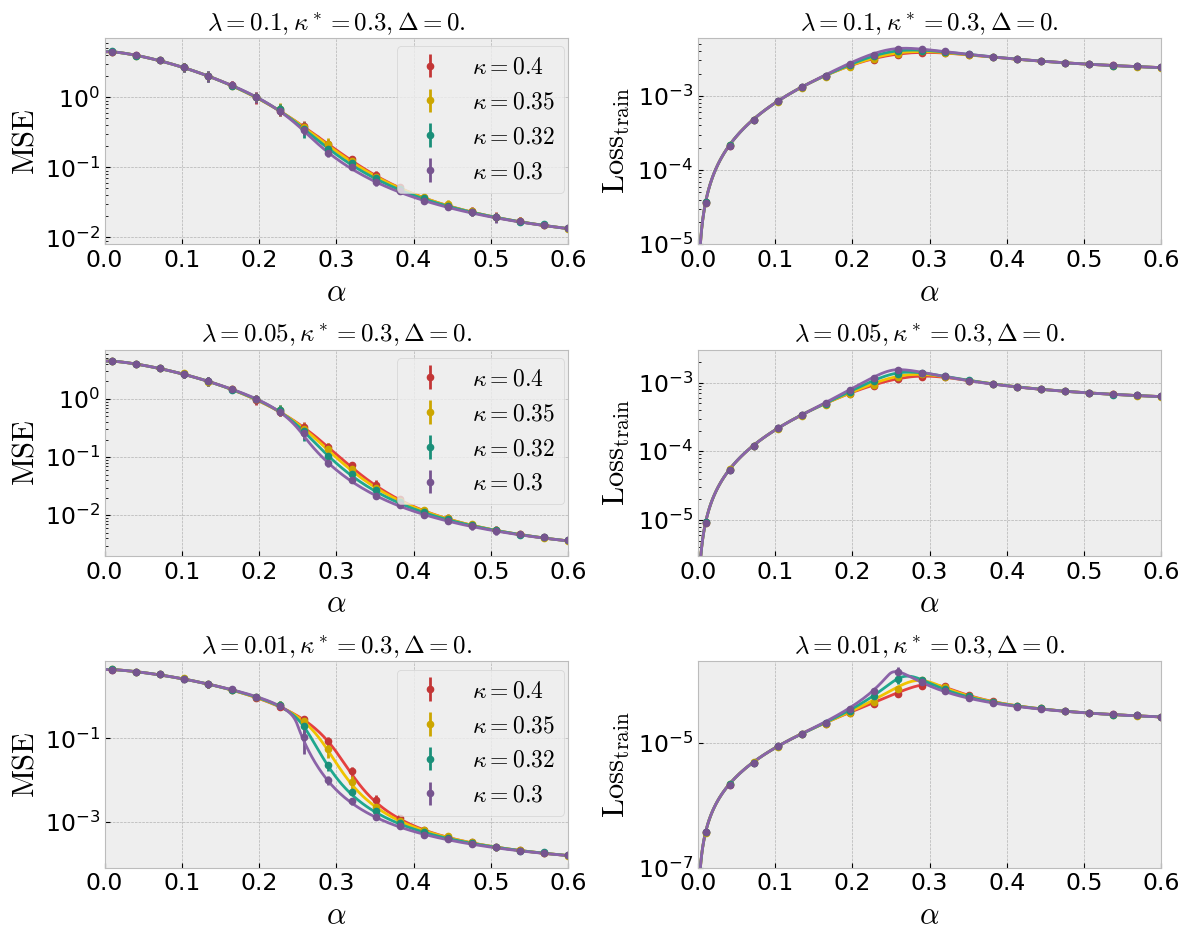

In [19]:
fig = plt.figure(figsize=(12, 9.5))

ind_colors = [0, 3, 6, 10]

limsMSE = [[8e-3, 7], [2e-3, 7], [8e-5, 7]]
limsLoss = [[1e-5, 6e-3], [3e-6, 3e-3], [1e-7, 2e-4]]

kappa = np.array([0.4, 0.35, 0.32, 0.3])
kappastar = 0.3
lam = np.array([0.1, 0.05, 0.01])

path = '../GDSimulations/postprocess/Fig16/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
Loss = torch.load(path + 'loss.pt')

with open('../HDSimulations/Simulators/SimHD_Figure16.pickle', "rb") as file:
    SHD = pickle.load(file)

for j in range(len(lam)):
    ax = fig.add_subplot(len(lam), 2, 2*j+1)
    for i in range(len(kappa)):
        M = MSE[i][j]
        mean = torch.mean(M, dim=-1)
        var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
        sigma = torch.sqrt(var)
        ax.errorbar(alpha[i][j], mean, yerr=2*sigma, color=colors_dark[ind_colors[i]], fmt='o', ms=4.5, label=r'$\kappa = {}$'.format(kappa[i]))
        ax.plot(SHD.alpha[i][j], SHD.mse[i][j], color=colors[ind_colors[i]])

    ax.set_ylim(limsMSE[j][0], limsMSE[j][1])
    ax.set_yscale('log')
    ax.set_title(r'$\lambda = {0}, \kappa^* = {1}, \Delta = 0.$'.format(lam[j], kappastar), fontsize=18)

    ax.legend(loc=(0.63, 0.25), fontsize=17)
    ax.set_xlim(0., 0.6)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\mathrm{MSE}$')

    ax = fig.add_subplot(len(lam), 2, 2*j+2)
    for i in range(len(kappa)):
        M = Loss[i][j]
        mean = torch.mean(M, dim=-1)
        var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
        sigma = torch.sqrt(var)
        ax.errorbar(alpha[i][j], mean, yerr=2*sigma, color=colors_dark[ind_colors[i]], fmt='o', ms=4.5, label=r'$\kappa = {}$'.format(kappa[i]))
        ax.plot(SHD.alpha[i][j], SHD.loss[i][j], color=colors[ind_colors[i]])

    ax.set_ylim(limsLoss[j][0], limsLoss[j][1])
    ax.set_yscale('log')    
    ax.set_title(r'$\lambda = {0}, \kappa^* = {1}, \Delta = 0.$'.format(lam[j], kappastar), fontsize=18)
    ax.set_xlim(0., 0.6)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\mathrm{Loss}_\mathrm{train}$')

plt.tight_layout()
plt.savefig('Figure16.pdf', format='pdf')
plt.show()

#### **Figure 17**

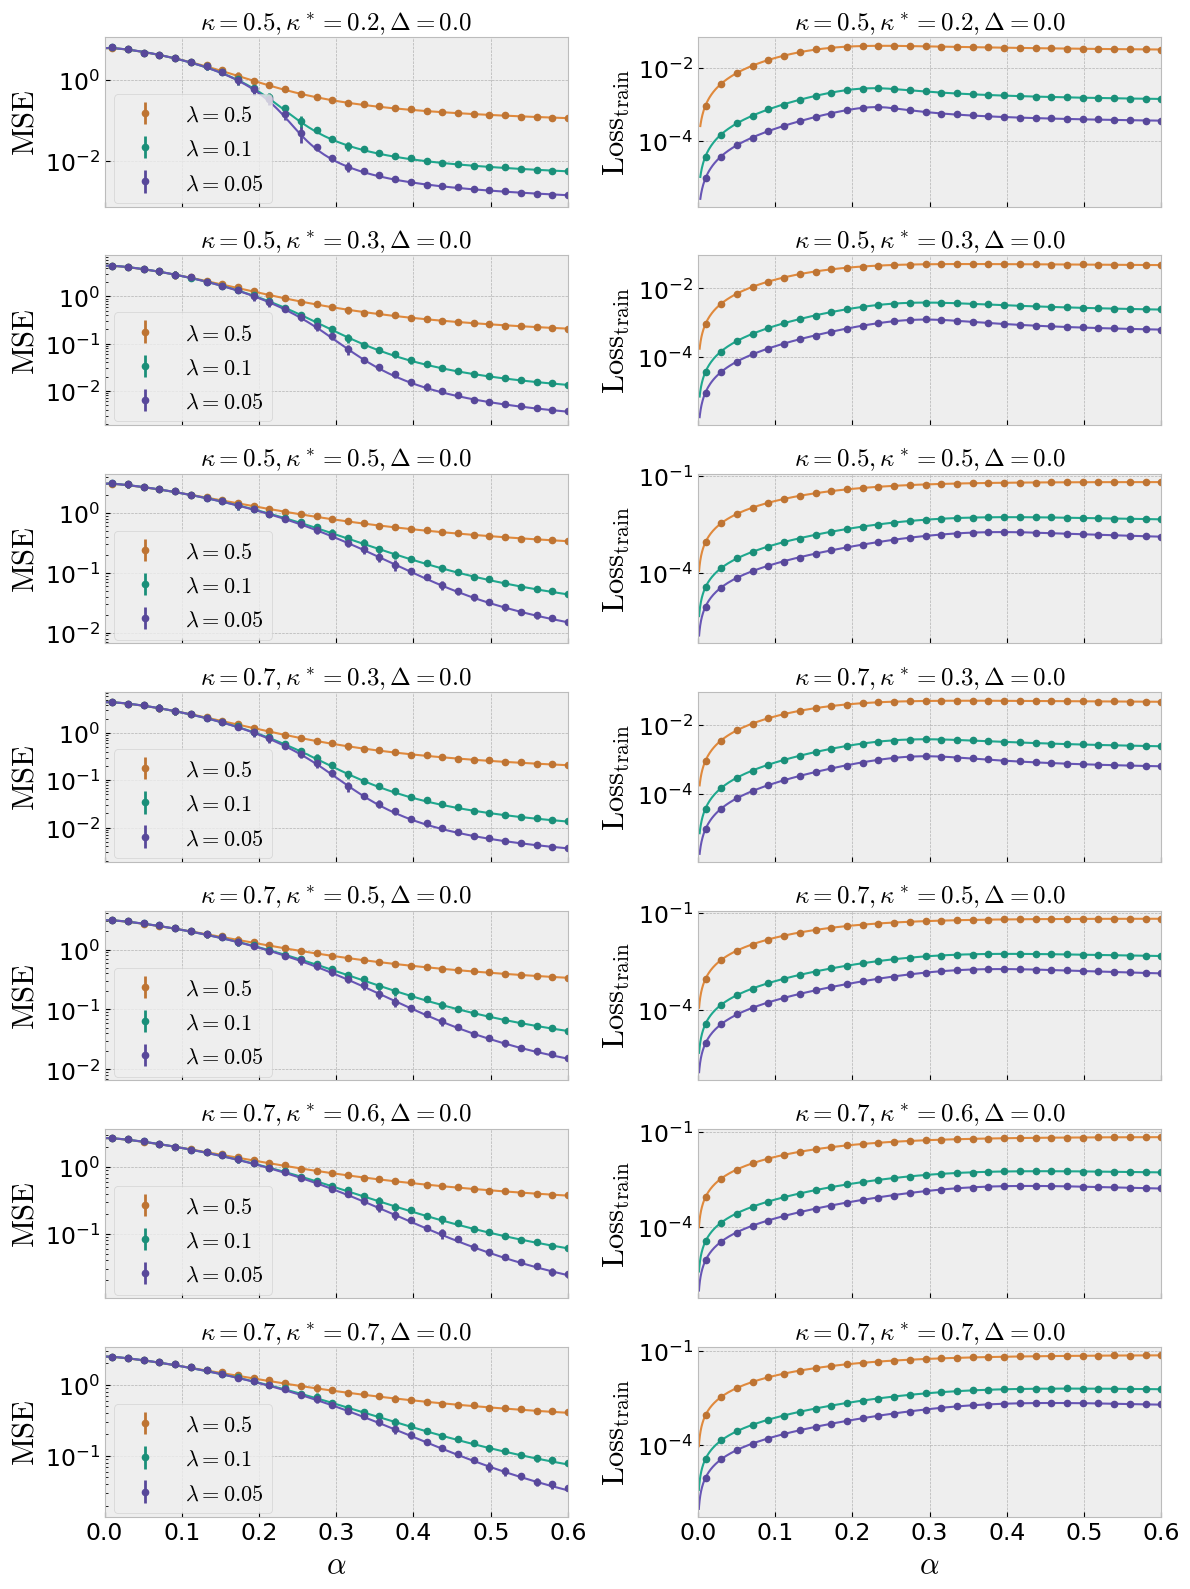

In [20]:
fig = plt.figure(figsize=(12, 16))

ind_colors = [2, 6, 9]

with open('../HDSimulations/Simulators/SimHD_Figure17.pickle', "rb") as file:
    SHD = pickle.load(file)

kappa = np.array([0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7])
kappastar = np.array([0.2, 0.3, 0.5, 0.3, 0.5, 0.6, 0.7])
lam = np.array([0.5, 0.1, 0.05])
delta = 0.

path = '../GDSimulations/postprocess/Fig17/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
Loss = torch.load(path + 'loss.pt')

for i in range(len(kappa)):
    ax1 = fig.add_subplot(len(kappa), 2, 2*i + 1)
    for j in range(len(lam)):
        a = alpha[i][j]
        M = MSE[i][j]
        mean = torch.mean(M, dim=-1)
        var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
        sigma = torch.sqrt(var)

        ax1.errorbar(a, mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=4.5, label=r'$\lambda = {}$'.format(lam[j]))
        ax1.plot(SHD.alpha[i,j], SHD.mse[i,j], color=colors[ind_colors[j]], linewidth=1.5)

    ax1.set_ylabel(r'$\mathrm{MSE}$')
    ax1.set_title(r'$\kappa = {0}, \kappa^* = {1}, \Delta = {2} $'.format(kappa[i], kappastar[i], delta), fontsize=18)
    ax1.set_xlim(0., 0.6)
    ax1.set_yscale('log')

    if i < len(kappa) - 1:
        ax1.tick_params(labelbottom=False)
        ax1.set_xlabel('')
    else:
        ax1.set_xlabel(r'$\alpha$')

    ax1.legend(loc=(0.02, 0.02), fontsize=16)

    ax2 = fig.add_subplot(len(kappa), 2, 2*i + 2)
    for j in range(len(lam)):
        a = alpha[i][j]
        M = Loss[i][j]
        mean = torch.mean(M, dim=-1)
        var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
        sigma = torch.sqrt(var)

        ax2.errorbar(a, mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=4.5, label=r'$\lambda = {}$'.format(lam[j]))
        ax2.plot(SHD.alpha[i,j], SHD.loss[i,j], color=colors[ind_colors[j]], linewidth=1.5)

    ax2.set_ylabel(r'$\mathrm{Loss}_\mathrm{train}$')
    ax2.set_title(r'$\kappa = {0}, \kappa^* = {1}, \Delta = {2} $'.format(kappa[i], kappastar[i], delta), fontsize=18)
    ax2.set_xlim(0., 0.6)
    ax2.set_yscale('log')

    if i < len(kappa) - 1:
        ax2.tick_params(labelbottom=False)
        ax2.set_xlabel('')
    else:
        ax2.set_xlabel(r'$\alpha$')

plt.tight_layout()
plt.savefig('Figure17.pdf', format='pdf')
plt.show()

#### **Figure 18**

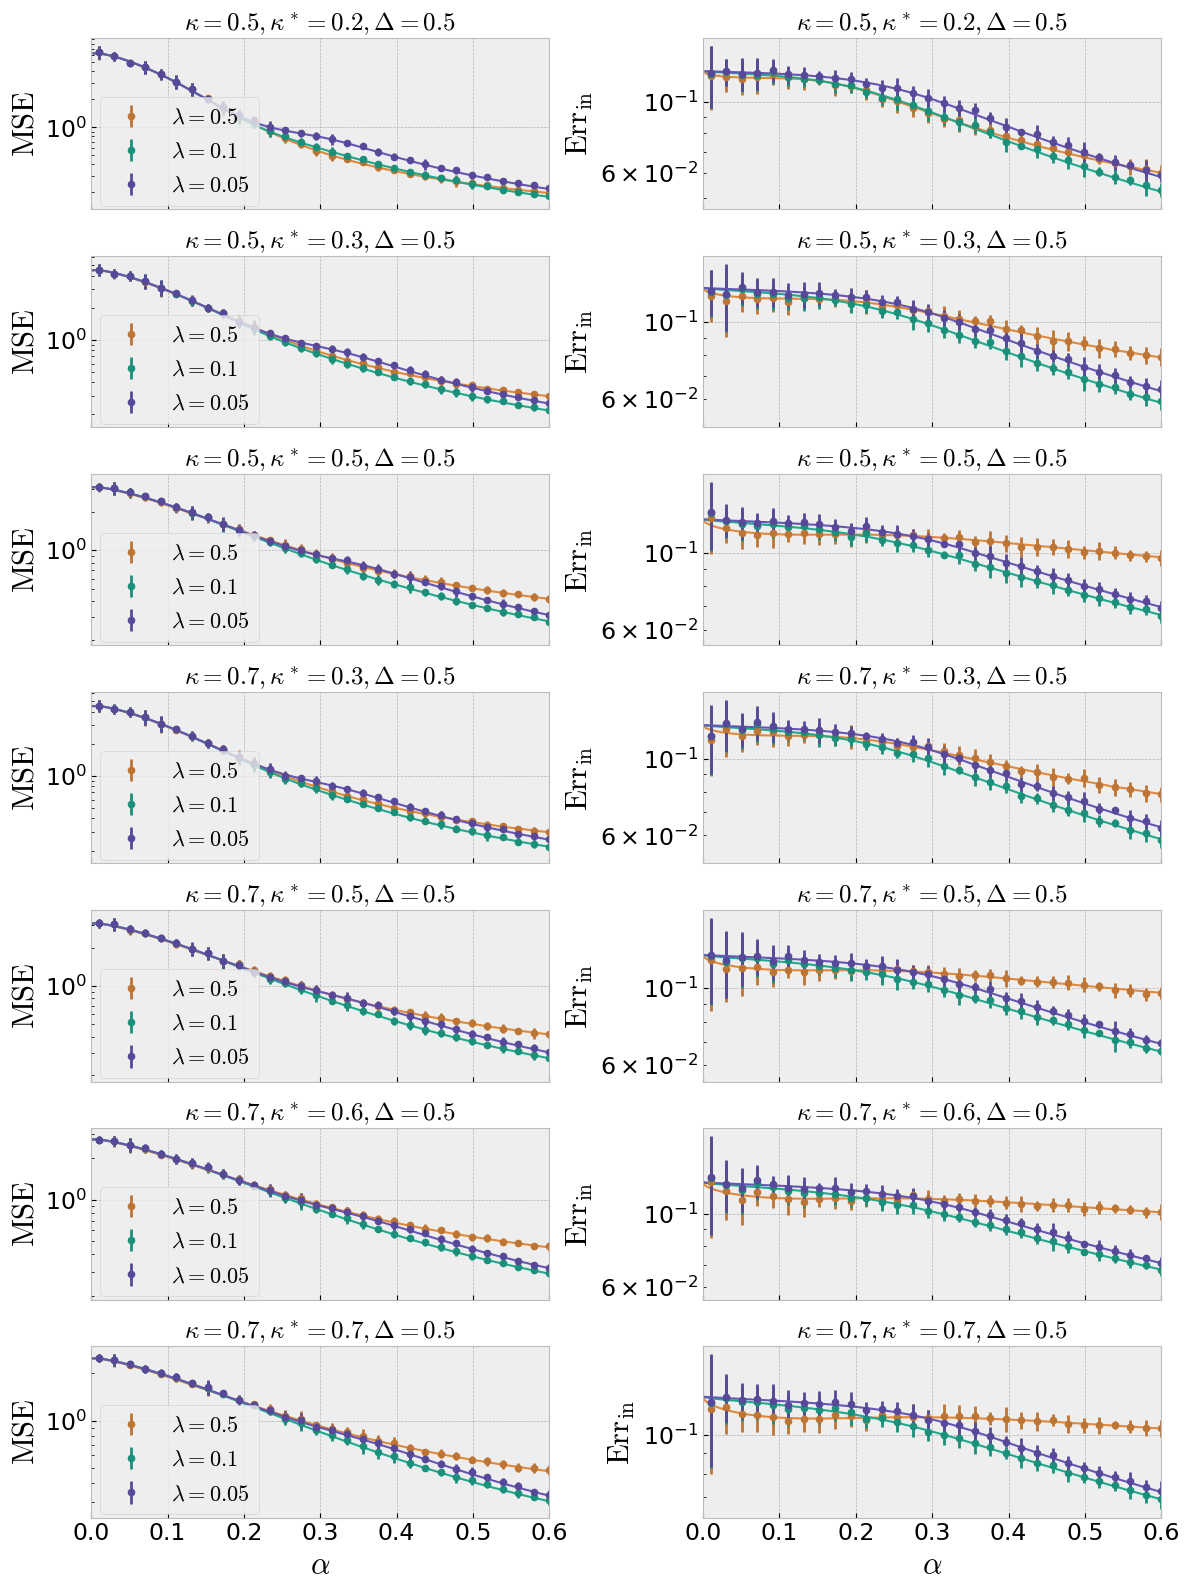

In [21]:
fig = plt.figure(figsize=(12, 16))

ind_colors = [2, 6, 9]

with open('../HDSimulations/Simulators/SimHD_Figure18.pickle', "rb") as file:
    SHD = pickle.load(file)

kappa = np.array([0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7])
kappastar = np.array([0.2, 0.3, 0.5, 0.3, 0.5, 0.6, 0.7])
lam = np.array([0.5, 0.1, 0.05])
delta = 0.5

path = '../GDSimulations/postprocess/Fig18/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
ISE = torch.load(path + 'ISE.pt')

for i in range(len(kappa)):
    ax1 = fig.add_subplot(len(kappa), 2, 2*i + 1)
    for j in range(len(lam)):
        a = alpha[i][j]
        M = MSE[i][j]
        mean = torch.mean(M, dim=-1)
        var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
        sigma = torch.sqrt(var)

        ax1.errorbar(a, mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=4.5, label=r'$\lambda = {}$'.format(lam[j]))
        ax1.plot(SHD.alpha[i,j], SHD.mse[i,j], color=colors[ind_colors[j]], linewidth=1.5)

    ax1.set_ylabel(r'$\mathrm{MSE}$')
    ax1.set_title(r'$\kappa = {0}, \kappa^* = {1}, \Delta = {2}$'.format(kappa[i], kappastar[i], delta), fontsize=18)
    ax1.set_xlim(0., 0.6)
    ax1.set_yscale('log')
    if i < len(kappa) - 1:
        ax1.tick_params(labelbottom=False)
        ax1.set_xlabel('')
    else:
        ax1.set_xlabel(r'$\alpha$')

    ax1.legend(loc=(0.02, 0.02), fontsize=16)

    ax2 = fig.add_subplot(len(kappa), 2, 2*i + 2)

    for j in range(len(lam)):
        a = alpha[i][j]
        M = ISE[i][j]
        mean = torch.mean(M, dim=-1)
        var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
        sigma = torch.sqrt(var)

        ax2.errorbar(a, mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=4.5, label=r'$\lambda = {}$'.format(lam[j]))
        ax2.plot(SHD.alpha[i,j], SHD.loss[i,j], color=colors[ind_colors[j]], linewidth=1.5)

    ax2.set_ylabel(r'$\mathrm{Err}_\mathrm{in}$')
    ax2.set_title(r'$\kappa = {0}, \kappa^* = {1}, \Delta = {2}$'.format(kappa[i], kappastar[i], delta), fontsize=18)
    ax2.set_xlim(0., 0.6)
    ax2.set_yscale('log')
    ax2.set_yticks([1e-1])
    if i < len(kappa) - 1:
        ax2.tick_params(labelbottom=False)
        ax2.set_xlabel('')
    else:
        ax2.set_xlabel(r'$\alpha$')
    
plt.tight_layout()
plt.savefig('Figure18.pdf', format='pdf')
plt.show()

#### **Figure 19**

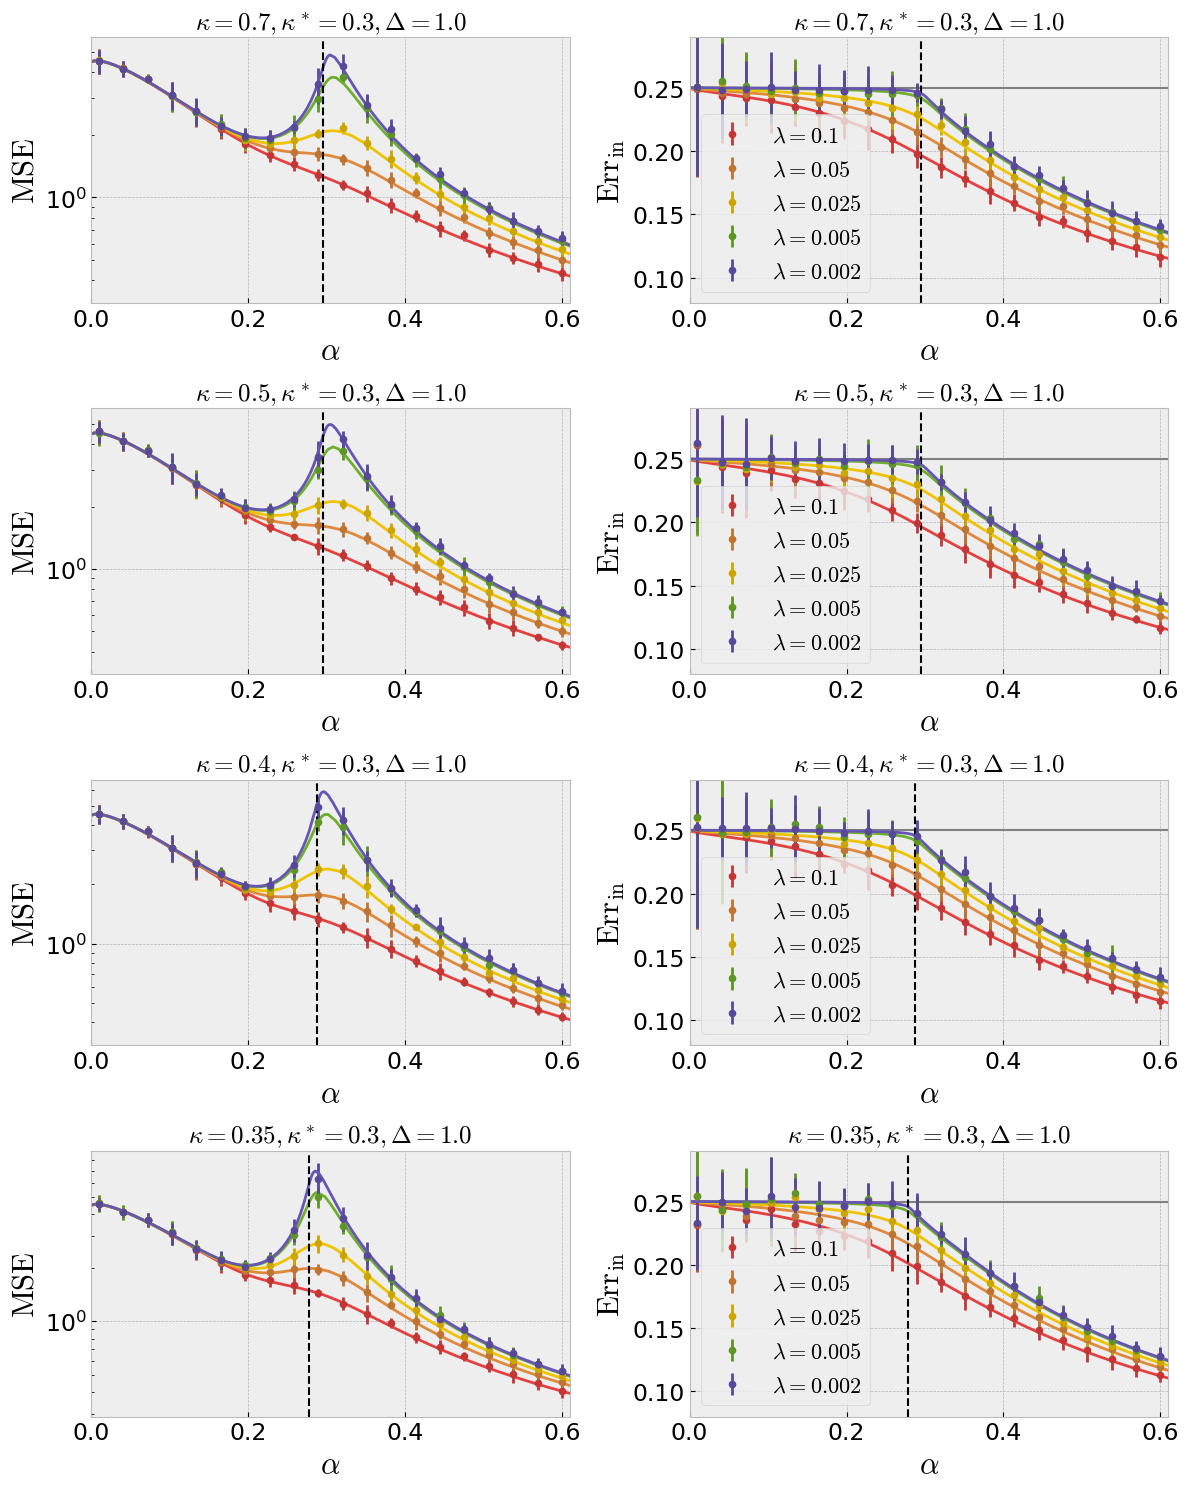

In [22]:
kappa = [0.7, 0.5, 0.4, 0.35]
kappastar = 0.3
lam = [0.1, 0.05, 0.025, 0.005, 0.002]
delta = 1.0

ind_colors = [0, 2, 3, 5, 9]

fig = plt.figure(figsize=(12, 15))

with open('../HDSimulations/Simulators/SimHD_Figure19.pickle', "rb") as file:
    SHD = pickle.load(file)

path = '../GDSimulations/postprocess/Fig19/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')
ISE = torch.load(path + 'ISE.pt')

alpha_inter = [mhd.interpolation_treshold(k, kappastar, delta)[1] for k in kappa]

for i in range(4):
    fig.add_subplot(len(kappa), 2, 2*i+1)
    for j in range(5):
        M = MSE[i][j]
        mean = torch.mean(M, dim=-1)
        var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
        sigma = torch.sqrt(var)

        plt.errorbar(alpha[i][j], mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=4.5, label=r'$\lambda = {}$'.format(lam[j]))
    
        alphaHD = SHD.alpha[i][j]
        MSEHD = SHD.mse[i][j]
        plt.plot(alphaHD, MSEHD, color=colors[ind_colors[j]])

    plt.axvline(alpha_inter[i], color='black', linestyle='dashed', linewidth=1.5);

    plt.ylabel(r'$\mathrm{MSE}$')
    plt.xlabel(r'$\alpha$')
    plt.yscale('log')
    plt.xlim(0., 0.61)
    plt.title(r'$ \kappa = {0}, \kappa^* = {1}, \Delta = {2}$'.format(kappa[i], kappastar, delta), fontsize=18)

    fig.add_subplot(len(kappa), 2, 2*i+2)
    plt.axhline(delta / 4, color='gray', linewidth=1.5)
    for j in range(5):
        M = ISE[i][j]
        mean = torch.mean(M, dim=-1)
        var = torch.mean(M**2, dim=-1) - torch.mean(M, dim=-1)**2
        sigma = torch.sqrt(var)

        plt.errorbar(alpha[i][j], mean, yerr=2*sigma, color=colors_dark[ind_colors[j]], fmt='o', ms=4.5, label=r'$\lambda = {}$'.format(lam[j]))
        
        alphaHD = SHD.alpha[i][j]
        LossHD = SHD.loss[i][j]
        plt.plot(alphaHD, LossHD, color=colors[ind_colors[j]])

    plt.axvline(alpha_inter[i], color='black', linestyle='dashed', linewidth=1.5)
        
    plt.ylabel(r'$\mathrm{Err}_\mathrm{in}$')
    plt.xlabel(r'$\alpha$')
    plt.xlim(0., 0.61)
    plt.ylim(0.08, 0.29)
    plt.legend(fontsize=16)
    plt.title(r'$ \kappa = {0}, \kappa^* = {1}, \Delta = {2}$'.format(kappa[i], kappastar, delta), fontsize=18)

plt.tight_layout()
plt.savefig('Figure19.pdf', format='pdf')
plt.show()

#### **Figure 20**

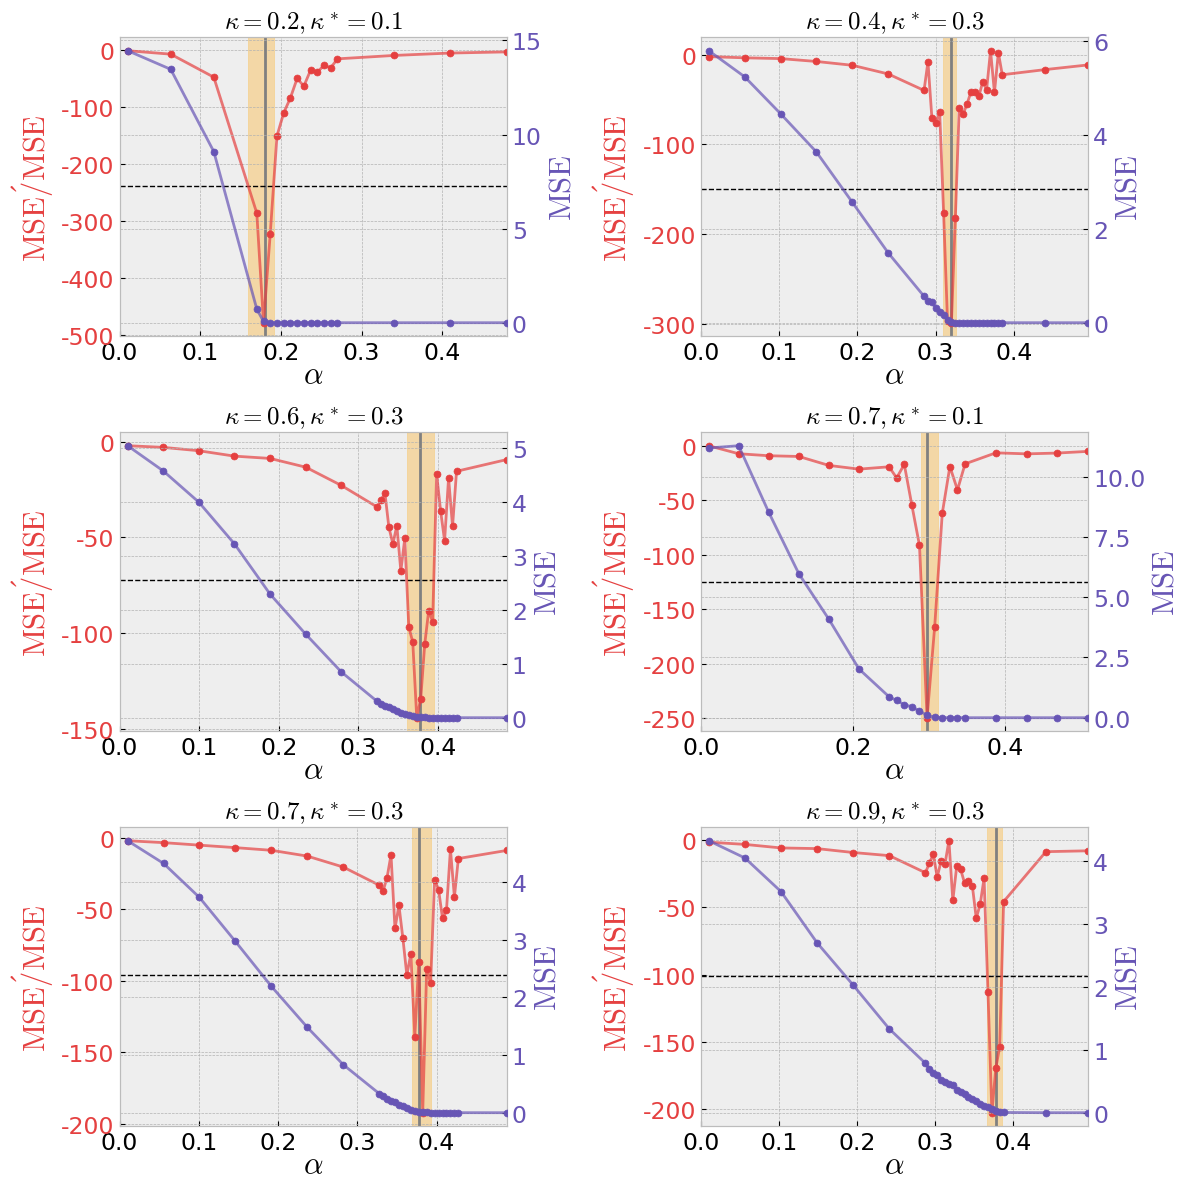

In [23]:
kappa = [0.2, 0.3, 0.3, 0.36, 0.4, 0.45, 0.5, 0.5, 0.5, 0.6, 0.6, 0.7, 
         0.7, 0.7, 0.7, 0.7, 0.75, 0.8, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
kappastar = [0.1, 0.1, 0.2, 0.1, 0.3, 0.2, 0.1, 0.3, 0.5, 0.3, 0.5, 0.1, 
             0.2, 0.3, 0.5, 0.7, 0.7, 0.3, 0.3, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

path = '../GDSimulations/postprocess/Fig20/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')

alphaPR = [utils.PR_threshold(kappa[i], kappastar[i]) for i in range(len(kappa))]

indices_plot = [0, 4, 9, 11, 13, 18]

fig = plt.figure(figsize=(12, 2 * len(indices_plot)))
for i in range(len(indices_plot)):
    j = indices_plot[i]
    ax = fig.add_subplot(3, 2, i + 1)
    ax.axvline(alphaPR[j], color='gray')

    a, D = utils.derivative(alpha[j], torch.log(MSE[j]))
    D = torch.stack(D)
    mean = torch.mean(D, dim=-1)
    low = torch.min(mean)

    ax.axhline(low / 2, color='black', linestyle='dashed', linewidth=1)

    inter = np.array(utils.horizontal_intersections(a, mean, low / 2))
    intervals = [np.min(inter), np.max(inter)]

    ax.plot(a, mean, color=colors[0], alpha=0.7)
    ax.scatter(a, mean, color=colors[0], s=25, zorder=3)
    ax.axvspan(intervals[0], intervals[1], alpha=0.3, color='orange')

    ax.set_ylabel(r'$\mathrm{MSE} \' / \mathrm{MSE}$', color=colors[0])
    ax.tick_params(axis='y', labelcolor=colors[0])
    ax.set_xlabel(r'$\alpha$', labelpad=-3)

    ax.set_xlim(0., a[-1])

    ax2 = ax.twinx()    
    mean2 = torch.mean(MSE[j], dim=-1)

    ax2.plot(alpha[j], mean2, color=colors[9], linewidth=2, alpha=0.7)
    ax2.scatter(alpha[j], mean2, color=colors[9], s=25, zorder=3)
    ax2.set_ylabel(r'$\mathrm{MSE}$', color=colors[9])
    ax2.tick_params(axis='y', labelcolor=colors[9])

    ax.set_title(r'$\kappa = {0}, \kappa^* = {1}$'.format(kappa[j], kappastar[j]), fontsize=18)

plt.tight_layout()
plt.savefig('Figure20.pdf', format='pdf')
plt.show()

#### **Figure 21**

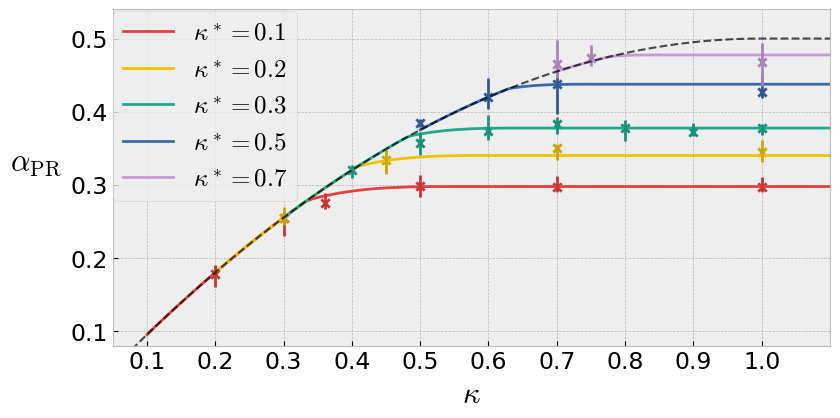

In [24]:
kappa = [0.2, 0.3, 0.3, 0.36, 0.4, 0.45, 0.5, 0.5, 0.5, 0.6, 0.6, 0.7, 
         0.7, 0.7, 0.7, 0.7, 0.75, 0.8, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
kappastar = [0.1, 0.1, 0.2, 0.1, 0.3, 0.2, 0.1, 0.3, 0.5, 0.3, 0.5, 0.1, 
             0.2, 0.3, 0.5, 0.7, 0.7, 0.3, 0.3, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

path = '../GDSimulations/postprocess/Fig20/'

alpha = torch.load(path + 'alpha.pt')
MSE = torch.load(path + 'MSE.pt')

kappastar_test = np.array([0.1, 0.2, 0.3, 0.5, 0.7])
kappa_test = [torch.linspace(ks, 1.1, 100) for ks in kappastar_test]

ind_colors = [0, 3, 6, 8, 11]

alphaPR_test = [[utils.PR_threshold(k, kappastar_test[i]) for k in kappa_test[i]] for i in range(len(kappa_test))]

fig = plt.figure(figsize=(8.5, 4.3))

for i in range(len(kappastar_test)):
    plt.plot(kappa_test[i], alphaPR_test[i], color=colors[ind_colors[i]], label=r'$\kappa^* = {}$'.format(kappastar_test[i]))

for i in range(len(kappa)):
    a, D = utils.derivative(alpha[i], torch.log(MSE[i]))
    D = torch.stack(D) 
    mean = torch.mean(D, dim=-1)    
    low = torch.min(mean)
    alpha_num = a[torch.argmin(mean)].item()
    inter = np.array(utils.horizontal_intersections(a, mean, low / 2))
    intervals = [np.min(inter), np.max(inter)]
    
    k = kappa[i]
    ks = kappastar[i]
    if ks in kappastar_test:
        ind = np.argwhere(ks == kappastar_test)[0][0]
        plt.vlines(k, intervals[0], intervals[1], color=colors_dark[ind_colors[ind]]) 
        plt.scatter([k], [alpha_num], color=colors_dark[ind_colors[ind]], marker='x')

k = np.linspace(0.01, 1.1, 500)
y = np.where(k < 1, k-k**2 / 2, 0.5)
plt.plot(k, y, color='black', linestyle='dashed', linewidth=1.5, alpha=0.7)

plt.legend(loc=(0., 0.43), fontsize=18)
plt.ylim(0.08, 0.54)
plt.xlim(0.05, 1.1)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\alpha_\mathrm{PR}$', rotation=0, labelpad=25)

ticks = np.arange(0.1, 1.01, 0.1)
plt.xticks(ticks)

plt.tight_layout()
plt.savefig('Figure21.pdf', format='pdf')
plt.show()